# Pricing n out of m Convertible Bond with Soft Call provision

### Background Research

I have refererd to the research paper 'Back To the Future - An Approximate Solution for n out of m Soft-call Option' by Joshua Xingzhi Zhang for pricing an 'n' out of 'm' days convertible bond. (Reference: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1815295)


Key Problem:
- In convertible bonds, soft-call constraints protect conversion privileges from being called away too early
- The typical requirement is that the stock must close above a preset barrier for n or more days out of m consecutive trading days (e.g., 20 out of 30 days)
- This path-dependent feature makes pricing challenging

Proposed Solution:
- The paper introduces a "Looking Backward" (LB) method for approximating the price
- Uses an auxiliary state variable to track the number of days the stock is above the barrier
- Calculates transition probabilities by looking backward m steps on the pricing tree
- Can be implemented on both binomial and trinomial trees

Key Features:
- More efficient than exact solutions while maintaining good accuracy
- Maximum error of about 30 basis points for trinomial tree implementation
- Maximum error of about 50 basis points for binomial tree implementation
- Can be extended to more general stock dynamics using PDE methods

Advantages over Existing Methods:
- More accurate than simple one-touch barrier approximations
- More computationally efficient than exact solutions
- Better theoretical foundation than some other approximation methods
- Can be extended to handle other path-dependent problems

Testing Results:
- The method was tested on a 5-year convertible bond with various parameters
- Performed well across different volatility levels (20% and 40%)
- Showed particular improvement over one-touch methods when stock prices were near the barrier
- Results were compared against exact solutions to validate accuracy

The paper concludes that this method provides a practical balance between computational efficiency and pricing accuracy, making it suitable for real-world applications in convertible bond markets.

I have tried to replicate the approach presented in the paper. However, it is to be noted I was unable to reproduce the exact values presented in the paper.

After generating a sufficiently large sample, I have fitted machine learning models to help predict the convertible bond price based on the various parameters.

In [ ]:
#importing necessary libraries
import numpy as np
import math
import time
from functools import lru_cache
import pandas as pd

## Part 1: Implement the Auxillary State Variable approach to price 'n' out of 'm' Convertible Bond with soft call

### Initialization and Basic Functions

Cache Dictionaries
We initialize three cache dictionaries to store frequently computed values:
- `price_tree_cache`: Stores pre-computed binomial price trees
- `M_table_cache`: Stores M-table values for barrier calculations
- `rho_cache`: Stores probability ratios for barrier monitoring

Binomial Coefficient Function
Calculates the binomial coefficient (c choose r) using Python's built-in `math.comb` function. This is used in probability calculations for the barrier monitoring process.

Barrier Parameter Calculation
Calculates the parameter 'b' which represents the number of up-moves needed for the stock price to cross the barrier level.

**Parameters:**
- `S0`: Initial stock price
- `H`: Barrier level
- `u`: Up-movement factor in the binomial tree
- `m`: Window size for barrier monitoring

**Implementation Details:**
1. If barrier is below initial price (H < S0), return 0
2. For each possible number of up-moves b:
   - Calculate price range after m-1 steps
   - Check if barrier H falls within this range
3. Return the first b that satisfies the condition, or m-1 if none found

**Mathematical Background:**
The function finds b where:
S0 u^b d^(m-1-b) ≤ H < S0 u^(b+1) d^(m-2-b)
This represents the price range after m-1 steps in the binomial tree.


In [ ]:
# Cache dictionaries
price_tree_cache = {}
M_table_cache = {}
rho_cache = {}

def binomial_coefficient(c,r):
    return math.comb(c,r)

def calculate_b(S0, H, u, m):
    """Calculate b based on trigger condition"""
    if H < S0:
        return 0
    d = 1/u
    def check_condition(b):
        lower_bound = S0 * (u**b) * (d**(m-1-b))
        upper_bound = S0 * (u**(b+1)) * (d**(m-2-b))
        return lower_bound <= H < upper_bound

    for b in range(m):
        if check_condition(b):
            return b

    return m-1

### Price Tree Construction

#### Function: build_price_tree
Constructs a binomial price tree for barrier monitoring with efficient caching mechanism.

**Parameters:**
- `m`: Window size for barrier monitoring (number of time steps)
- `S0`: Initial stock price
- `u`: Up-movement factor in the binomial tree

**Implementation Details:**
1. **Caching Mechanism:**
   - Creates a unique cache key from (m, S0, u)
   - Returns cached tree if already computed
   - Stores new computations for future use

2. **Tree Construction:**
   - Uses a dictionary to store prices at each node
   - Node (i,j) represents:
     * i: time step
     * j: number of up movements
   - Down factor d = 1/u (ensures no-arbitrage)

3. **Price Calculation:**
   - At each node (i,j):
     * Down movement: S(i+1,j) = S(i,j) * d
     * Up movement: S(i+1,j+1) = S(i,j) * u

**Mathematical Representation:**
S(i,j) = S0 u^j d^(i-j)
where:
- S(i,j) is the stock price at node (i,j)
- j is the number of up movements
- (i-j) is the number of down movements

**Memory Efficiency:**
- Uses dictionary structure instead of full matrix
- Implements caching to avoid redundant calculations
- Key for monitoring barrier crossings in the m-day window


In [ ]:
def build_price_tree(m, S0, u):
    """Build price tree with caching"""
    cache_key = (m, S0, float(u))
    if cache_key in price_tree_cache:
        return price_tree_cache[cache_key]

    d = 1/u
    prices = {}
    prices[(0,0)] = S0
    for i in range(m):
        for j in range(i+1):
            current_price = prices[(i,j)]
            prices[(i+1,j)] = current_price * d
            prices[(i+1,j+1)] = current_price * u

    price_tree_cache[cache_key] = prices
    return prices

### M-Table Calculation for Barrier Monitoring

#### Function: calculate_M_table
Computes the M-table which tracks the number of paths reaching each state (position, level) combination in the barrier monitoring process.

**Parameters:**
- `m`: Window size for barrier monitoring
- `S0`: Initial stock price
- `H`: Barrier level
- `u`: Up-movement factor
- `prices`: Pre-computed price tree

**Key Components:**

1. **Caching System:**
   - Uses cache key (H, m) for efficiency
   - Stores complete M-table calculations
   - Implements LRU cache for recursive calculations

2. **Helper Functions:**
   ```python
   def is_above_trigger(i, j):
       return prices[(i,j)] > H
   ```
   - Checks if price at node (i,j) exceeds barrier H
   - Critical for tracking barrier crossings

3. **Core Recursive Function:**
   ```python
   @lru_cache(maxsize=None)
   def get_M(step, pos, b, level)
   ```
   Parameters:
   - `step`: Current time step
   - `pos`: Position in binomial tree
   - `b`: Barrier parameter
   - `level`: Number of days above barrier

**Mathematical Foundation:**
- M(k,b,l,m) represents number of paths reaching:
  * Position k
  * With barrier parameter b
  * Having l days above barrier
  * In m total days

**Memory Optimization:**
- Uses dictionary structure for sparse storage
- Implements two-level caching:
  1. Complete M-table caching
  2. LRU cache for recursive calls


In [ ]:
def calculate_M_table(m, S0, H, u, prices):
    """Calculate M-table with caching"""
    cache_key = (H, m)
    if cache_key in M_table_cache:
        return M_table_cache[cache_key]

    M = {}
    b = calculate_b(S0, H, u, m)

    def is_above_trigger(i, j):
        return prices[(i,j)] > H

    @lru_cache(maxsize=None)
    def get_M(step, pos, b, level):
        if step == 0:
            return 1 if pos == 0 and level == 0 else 0

        if pos < 0 or pos > step or level < 0 or level > step:
            return 0

        key = (pos, b, level, step)
        if key in M:
            return M[key]

        paths = 0
        if pos > 0:
            prev_level = level - (1 if is_above_trigger(step, pos) else 0)
            paths += get_M(step-1, pos-1, b, prev_level)

        prev_level = level - (1 if is_above_trigger(step, pos) else 0)
        paths += get_M(step-1, pos, b, prev_level)

        M[key] = paths
        return paths

    for pos in range(m+1):
        for level in range(m+1):
            get_M(m, pos, b, level)

    result = (M, b)
    M_table_cache[cache_key] = result
    return result

### Probability Ratio (ρ) Calculation

#### Function: calculate_rho
Calculates the probability ratios (ρ) that determine the likelihood of the stock price being above or below the barrier, given the current state and history.

**Parameters:**
- `M`: M-table containing path counts
- `m`: Window size for monitoring
- `i`: Current time step
- `j`: Current position in tree
- `l`: Current level (days above barrier)
- `b`: Barrier parameter

**Implementation Details:**

1. **Caching Mechanism:**
   ```python
   cache_key = (i, j, l, b)
   ```
   - Stores previously calculated ρ values
   - Improves efficiency for repeated calculations

2. **Denominator Calculation:**
   ```python
   for k in range(m):
       if j+k-m+1 >= 0:
           binom = binomial_coefficient(j+k-m+1, i-m+1)
           M_value = M.get((k,b,l,m), 0)
   ```
   - Sums over all possible paths
   - Combines binomial coefficients with M-table values
   - Represents total probability space

3. **Numerator Calculation:**
   ```python
   for k in range(b+1):
   ```
   - Similar to denominator but only up to barrier parameter b
   - Represents paths staying below barrier

**Mathematical Foundation:**

ρ≤H = Numerator/Denominator
ρ>H = 1 - ρ≤H

Where:
- ρ≤H: Probability of staying below barrier
- ρ>H: Probability of crossing barrier

**Special Cases:**
- When denominator = 0:
  * ρ≤H = 0
  * ρ>H = 1
- Handles numerical stability with try-except blocks

**Return Value:**
Returns tuple (ρ≤H, ρ>H) representing:
1. Probability of price staying below barrier
2. Probability of price crossing barrier

The ρ values are crucial for:
- Determining barrier crossing probabilities
- Updating option values in the pricing tree
- Calculating soft call probabilities in convertible bond pricing

In [ ]:
def calculate_rho(M, m, i, j, l, b):
    """Calculate rho values with caching"""
    cache_key = (i, j, l, b)
    if cache_key in rho_cache:
        return rho_cache[cache_key]

    denominator = 0
    for k in range(m):
        try:
            if j+k-m+1 >= 0:
                binom = binomial_coefficient(j+k-m+1, i-m+1)
                M_value = M.get((k,b,l,m), 0)
                term = M_value * binom
                denominator += term
        except:
            continue

    if denominator == 0:
        # If denominator is zero, then rho<=H is 0 and rho>H is 1
        result = (0, 1)
        rho_cache[cache_key] = result
        return result

    numerator = 0
    for k in range(b+1):
        try:
            if j+k-m+1 >= 0:
                binom = binomial_coefficient(j+k-m+1, i-m+1)
                M_value = M.get((k,b,l,m), 0)
                term = M_value * binom
                numerator += term
        except:
            continue

    rho_less_equal = numerator / denominator if denominator > 0 else 0
    rho_greater = 1 - rho_less_equal if denominator > 0 else 0

    result = (rho_less_equal, rho_greater)
    rho_cache[cache_key] = result
    return result

### Convertible Bond Pricing with Soft Call Feature

#### Overview
This function implements a two-pass backward induction algorithm for pricing convertible bonds with a soft call feature that depends on barrier monitoring.

#### Key Parameters
- `S0, K, H`: Stock price, Strike price, Barrier level
- `T, r, sigma`: Time to maturity, Risk-free rate, Volatility
- `n, m, threshold`: Time steps, Monitoring window, Required days above barrier
- `conversion_ratio`: Number of shares per bond
- `par_value, coupon_rate`: Bond face value and coupon rate
- `soft/hard_call_price, hard_put_price`: Call and put prices

#### Implementation Structure

1. **Initialization Phase:**
   ```python
   n_2years = int(2/dt)  # First 2 years for soft call
   R = np.exp(r * dt)    # Discount factor
   u = np.exp(sigma * np.sqrt(dt))  # Up movement
   p = (R-d)/(u-d)      # Risk-neutral probability
   ```

2. **First Pass (T=5 to T=2):**
   - Regular CB pricing without barrier monitoring
   - Terminal values: `max(par_value, conversion_value)`
   - For each node (i,j):
     * At year 3: `max(min(rollover, hard_call), conversion, hard_put)`
     * Other times: `max(min(rollover, hard_call), conversion)`
   - Includes semi-annual coupon payments

3. **Second Pass (T=2 to T=0):**
   - Barrier monitoring for soft call feature
   - Three-dimensional array V[time][position][level]
   - Two scenarios based on barrier count (l):

   a) When l ≥ threshold (Soft call condition met):
   ```python
   value = max(min(rollover_value, soft_call_price), conversion_value)
   ```

   b) When l < threshold:
   - Above barrier:
     ```python
     pi_up = ρ≤H * V[l+1] + ρ>H * V[min(l+1,m)]
     ```
   - Below barrier:
     ```python
     pi_up = ρ≤H * V[l] + ρ>H * V[l]
     ```

### Key Features:
1. **Soft Call (Years 0-2):**
   - Monitored using barrier level H
   - Triggered after threshold days above barrier
   - Price capped at soft_call_price when triggered

2. **Hard Call (Years 2-5):**
   - No barrier monitoring
   - Issuer can call at hard_call_price

3. **Hard Put (Year 3):**
   - Holder can put at hard_put_price
   - Additional protection for bondholders

4. **Conversion Option:**
   - Available throughout bond life
   - Value = stock_price * conversion_ratio

5. **Coupon Payments:**
   - Semi-annual payments
   - Amount = par_value * (coupon_rate/2)

#### Return Value
Returns the convertible bond value at time 0, considering:
- Initial barrier status (l0)
- All embedded options (soft/hard call, put)
- Conversion rights
- Coupon payments


In [ ]:
def price_convertible_bond(S0, K, H, T, r, sigma, n, m, M, b, threshold,
                                     conversion_ratio, par_value, coupon_rate,
                                     soft_call_price, hard_call_price, hard_put_price):
    """Price convertible bond using barrier option methodology"""
    n = int(n)
    dt = T/n
    n_2years = int(2/dt)  # Number of steps in first 2 years

    # Pre-calculate common values
    R = np.exp(r * dt)
    u = np.exp(sigma * np.sqrt(dt))
    d = 1/u
    p = (R-d)/(u-d)
    q = 1 - p

    # Pre-calculate stock prices
    S = np.zeros((n + 1, n + 1))
    j_indices, i_indices = np.meshgrid(np.arange(n + 1), np.arange(n + 1))
    mask = j_indices <= i_indices
    S[mask] = S0 * (u**j_indices[mask]) * (d**(i_indices[mask]-j_indices[mask]))

    # Initialize regular CB values (without barrier tracking)
    V_reg = np.zeros((n + 1, n + 1))

    # Terminal values at T=5
    conversion_values = S[n,:] * conversion_ratio
    V_reg[n,:] = np.maximum(par_value, conversion_values)

    # Pre-calculate coupon dates (semi-annual)
    coupon_dates = set()
    for year in range(int(T)):
        coupon_dates.add(year + 0.5)  # Mid-year coupon
        coupon_dates.add(year + 1.0)  # Year-end coupon

    # First pass: Calculate regular CB values from T=5 to T=2
    for i in range(n-1, n_2years-1, -1):
        current_time = i * dt
        
        # Check if current time is close to a coupon date
        coupon_amount = 0
        for coupon_date in coupon_dates:
            if abs(current_time - coupon_date) < dt/2:
                coupon_amount = par_value * (coupon_rate/2)
                break

        for j in range(i + 1):
            current_price = S[i,j]
            conversion_value = current_price * conversion_ratio
            rollover_value = (p * V_reg[i+1,j+1] + q * V_reg[i+1,j]) / R + coupon_amount

            if abs(current_time - 3) < dt/2:  # At year 3
                value = max(
                    max(
                        min(rollover_value, hard_call_price),
                        conversion_value
                    ),
                    hard_put_price
                )
            else:
                value = max(
                    min(rollover_value, hard_call_price),
                    conversion_value
                )
            V_reg[i,j] = value

    # Initialize barrier tracking values for T=2 to T=0
    V = np.zeros((n_2years + 1, n_2years + 1, m + 1))

    # Set terminal values at T=2 from regular CB calculation
    for j in range(n_2years + 1):
        for l in range(m + 1):
            V[n_2years,j,l] = V_reg[n_2years,j]

    # Second pass: Calculate values with barrier tracking from T=2 to T=0
    for i in range(n_2years-1, -1, -1):
        current_time = i * dt
        
        # Check if current time is close to a coupon date
        coupon_amount = 0
        for coupon_date in coupon_dates:
            if abs(current_time - coupon_date) < dt/2:
                coupon_amount = par_value * (coupon_rate/2)
                break

        for j in range(i + 1):
            current_price = S[i,j]
            conversion_value = current_price * conversion_ratio

            for l in range(m + 1):
                rho_up = calculate_rho(M, m, i+1, j+1, l, b)
                rho_down = calculate_rho(M, m, i+1, j, l, b)

                if l >= threshold:
                    pi_up = V[i+1,j+1,l]
                    pi_down = V[i+1,j,l]
                    rollover_value = (p * pi_up + q * pi_down) / R + coupon_amount
                    value = max(min(rollover_value, soft_call_price), conversion_value)
                else:
                    if current_price > H:  # Above barrier
                        pi_up = (rho_up[0] * V[i+1,j+1,l+1] +
                                rho_up[1] * V[i+1,j+1,min(l+1,m)])
                        pi_down = (rho_down[0] * V[i+1,j,l] +
                                 rho_down[1] * V[i+1,j,l])
                    else:  # Below barrier
                        pi_up = (rho_up[0] * V[i+1,j+1,l] +
                                rho_up[1] * V[i+1,j+1,l])
                        pi_down = (rho_down[0] * V[i+1,j,l] +
                                 rho_down[1] * V[i+1,j,l])
                    
                    rollover_value = (p * pi_up + q * pi_down) / R + coupon_amount
                    value = max(rollover_value, conversion_value)

                V[i,j,l] = value
                
    # Calculate l0 - current level based on initial stock price
    l0 = 0
    if S0 > H:  # If starting price is above barrier
        l0 = 1  # Start with 1 day above barrier

    # Return value for state l0 at time 0
    return float(V[0,0,l0])

### Barrier Price Interpolation for Convertible Bonds

#### Function: interpolate_cb_price
Implements linear interpolation for convertible bond prices when the desired barrier level doesn't align with the binomial tree nodes.

#### Mathematical Foundation

The interpolation is based on the principle:
```
P(H) = P(H_in) * (1-w) + P(H_out) * w
where w = (H - H_in)/(H_out - H_in)
```

#### Implementation Steps:

1. **Barrier Level Identification:**
   ```python
   H_in = S0
   H_out = S0 * u
   while H_out < H:
       j += 1
       H_in = H_out
       H_out = H_in * u
   ```
   - Finds closest inner and outer barriers in tree
   - H_in ≤ H ≤ H_out
   - Uses tree's natural spacing (u factor)

2. **Price Calculation at Boundaries:**
   ```python
   Inner barrier price
   M_in, b_in = calculate_M_table(m, S0, H_in, u, prices)
   price_in = price_convertible_bond(..., H_in, ...)

   Outer barrier price
   M_out, b_out = calculate_M_table(m, S0, H_out, u, prices)
   price_out = price_convertible_bond(..., H_out, ...)
   ```
   - Computes M-tables and prices at both barriers
   - Uses full CB pricing methodology

3. **Linear Interpolation:**
   ```python
   w = (H - H_in) / (H_out - H_in)
   interpolated_price = price_in * (1 - w) + price_out * w
   ```
   - Weights based on relative position of H
   - Linear combination of boundary prices

#### Key Features:
1. **Accuracy Enhancement:**
   - Smooths price transitions between tree levels
   - Reduces discretization errors

2. **Efficiency:**
   - Reuses price tree for both calculations
   - Caches M-table calculations

3. **Special Case Handling:**
   ```python
   if H_out == H_in:
       return price_in
   ```
   - Handles exact matches to tree nodes

#### Parameters:
- Standard CB parameters (S0, K, T, r, sigma, etc.)
- Barrier-specific parameters (H, threshold, m)
- Bond-specific parameters (conversion_ratio, par_value, etc.)
- Call/Put prices for all features


In [ ]:
def interpolate_cb_price(S0, K, H, T, r, sigma, n, m, threshold,
                        conversion_ratio, par_value, coupon_rate,
                        soft_call_price, hard_call_price, hard_put_price):
    """
    Calculate CB price using barrier interpolation
    H_in <= H <= H_out
    """
    dt = T/n
    u = np.exp(sigma * np.sqrt(dt))
    d = 1/u

    # Find inner and outer barriers
    j = 0
    H_in = S0
    H_out = S0 * u
    while H_out < H:
        j += 1
        H_in = H_out
        H_out = H_in * u

    # Calculate prices at inner and outer barriers
    prices = build_price_tree(m, S0, u)

    # Price with inner barrier
    M_in, b_in = calculate_M_table(m, S0, H_in, u, prices)
    price_in = price_convertible_bond(S0, K, H_in, T, r, sigma, n, m, M_in, b_in,
                                    threshold, conversion_ratio, par_value, coupon_rate,
                                    soft_call_price, hard_call_price, hard_put_price)

    # Price with outer barrier
    M_out, b_out = calculate_M_table(m, S0, H_out, u, prices)
    price_out = price_convertible_bond(S0, K, H_out, T, r, sigma, n, m, M_out, b_out,
                                     threshold, conversion_ratio, par_value, coupon_rate,
                                     soft_call_price, hard_call_price, hard_put_price)

    # Linear interpolation
    if H_out == H_in:
        return price_in

    w = (H - H_in) / (H_out - H_in)
    interpolated_price = price_in * (1 - w) + price_out * w

    return interpolated_price

In [ ]:
if __name__ == "__main__":
    # Base Parameters
    S0 = 100          # Initial stock price
    K = 110           # Strike price
    T = 5.0           # Time to maturity in years
    r = 0.05          # Risk-free rate
    n = T*250         # Number of time steps (daily steps)
    m = 30            # Window size for barrier monitoring
    threshold = 20    # Required number of days above barrier
    conversion_ratio = 1.0  # Number of shares per bond
    par_value = 100   # Face value of the bond
    coupon_rate = 0.08     # Annual coupon rate (8%)
    hard_call_price = 110  # Hard call price (years 2-5)
    hard_put_price = 105   # Hard put price (at year 3)
    soft_call_price = 110  # Soft call price (years 0-2)

    # Volatility scenarios
    sigma_scenarios = [0.2, 0.4]
    
    try:
        # Create barrier levels from 100 to 160 with 0.5 increment
        barriers = np.arange(90, 170.5, 0.5)
        all_results = []

        for sigma in sigma_scenarios:
            print(f"\nCalculating prices for volatility = {sigma}")
            print("-" * 80)
            print(f"{'Barrier (H)':15} {'Bond Price':15}")
            print("-" * 80)

            for H in barriers:
                # Calculate bond price with interpolation
                bond_price = interpolate_cb_price(
                    S0, K, H, T, r, sigma, n, m, threshold,
                    conversion_ratio, par_value, coupon_rate,
                    soft_call_price, hard_call_price, hard_put_price
                )

                # Store all parameters along with results
                result = {
                    'Sigma': sigma,
                    'Barrier': H,
                    'Bond_Price': bond_price,
                    'S0': S0,
                    'K': K,
                    'T': T,
                    'r': r,
                    'n': n,
                    'm': m,
                    'threshold': threshold,
                    'conversion_ratio': conversion_ratio,
                    'par_value': par_value,
                    'coupon_rate': coupon_rate,
                    'hard_call_price': hard_call_price,
                    'hard_put_price': hard_put_price,
                    'soft_call_price': soft_call_price
                }
                
                all_results.append(result)
                print(f"{H:15.2f} {bond_price:15.4f}")
                print("-" * 80)

        # Convert to DataFrame and save
        df = pd.DataFrame(all_results)
        
        # Sort by sigma and barrier
        df = df.sort_values(['Sigma', 'Barrier'])
        
        # Create filename with key parameters
        filename = 'cb_prices_combined.csv'
        df.to_csv(filename, index=False)
        print(f"\nResults saved to {filename}")

        

    except Exception as e:
        print(f"\nAn error occurred: {str(e)}")

## Part 2: Building Machine Learning Models to predict the CB price

In this part, we will use some machine learning tools to predict the CB price from the given features.

In [ ]:
#!pip install tensorflow

In [1]:
#importing libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor  # Simple neural network
from sklearn.model_selection import train_test_split,cross_val_score  # for splitting data
from sklearn.metrics import mean_squared_error, r2_score  # for model evaluation
from sklearn.preprocessing import StandardScaler  # for feature scaling
from sklearn.base import BaseEstimator, RegressorMixin
import time
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


import warnings
warnings.filterwarnings('ignore')

In [2]:
filename = 'cb_prices_combined.csv'
df = pd.read_csv(filename)

In [5]:
df.shape

(322, 16)

In [7]:
df.head()

,Sigma,Barrier,Bond_Price,S0,K,T,r,n,m,threshold,conversion_ratio,par_value,coupon_rate,hard_call_price,hard_put_price,soft_call_price
0,0.2,90.0,106.464971,100,110,5.0,0.05,1800.0,30,20,1.0,100,0.08,110,105,110
1,0.2,90.5,106.604738,100,110,5.0,0.05,1800.0,30,20,1.0,100,0.08,110,105,110
2,0.2,91.0,106.744505,100,110,5.0,0.05,1800.0,30,20,1.0,100,0.08,110,105,110
3,0.2,91.5,106.884272,100,110,5.0,0.05,1800.0,30,20,1.0,100,0.08,110,105,110
4,0.2,92.0,107.024039,100,110,5.0,0.05,1800.0,30,20,1.0,100,0.08,110,105,110


In [9]:
#splitting the dataframes into two datasets - sigma of 0.20 and 0.40
df_20 = df[df['Sigma'] == 0.2].copy()
df_40 = df[df['Sigma'] == 0.4].copy()

## Exploratory Data Analysis

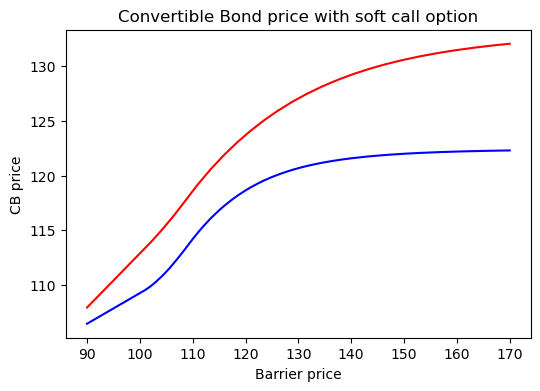

In [11]:
#plot of the CB price against the barrier price
plt.figure(figsize=(6,4))
plt.plot(df_20['Barrier'],df_20['Bond_Price'],label = 'Sigma 20%', color = 'blue')
plt.plot(df_40['Barrier'],df_40['Bond_Price'], label = 'Sigma 40%', color = 'red')
plt.title('Convertible Bond price with soft call option')
plt.xlabel('Barrier price')
plt.ylabel('CB price')
plt.show()

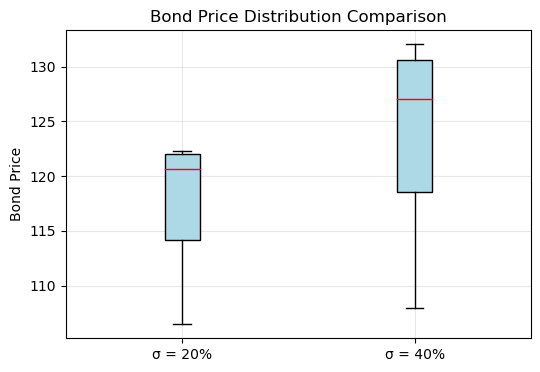

In [13]:
plt.figure(figsize=(6, 4))

# Create boxplot with both distributions
plt.boxplot([df_20['Bond_Price'], df_40['Bond_Price']], 
           patch_artist=True,  # Fill boxes
           boxprops=dict(facecolor='lightblue'),  # Box color
           medianprops=dict(color='red'),  # Median line color
           labels=['σ = 20%', 'σ = 40%'])  # Labels for each box

plt.title('Bond Price Distribution Comparison')
plt.ylabel('Bond Price')
plt.grid(True, alpha=0.3)

plt.show()

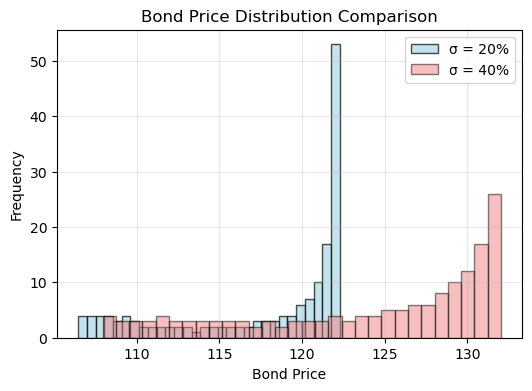

In [15]:
plt.figure(figsize=(6, 4))

# Create histograms for both distributions
plt.hist(df_20['Bond_Price'], 
         bins=30,
         color='lightblue',
         edgecolor='black',
         alpha=0.7,
         label='σ = 20%')

plt.hist(df_40['Bond_Price'], 
         bins=30,
         color='lightcoral',
         edgecolor='black',
         alpha=0.5,
         label='σ = 40%')

plt.title('Bond Price Distribution Comparison')
plt.xlabel('Bond Price')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.legend()

plt.show()

In [17]:
df_20.columns

Index(['Sigma', 'Barrier', 'Bond_Price', 'S0', 'K', 'T', 'r', 'n', 'm',
       'threshold', 'conversion_ratio', 'par_value', 'coupon_rate',
       'hard_call_price', 'hard_put_price', 'soft_call_price'],
      dtype='object')

In [19]:
#splitting the datasets into training and test for sigma of 0.20
X = df[['Sigma', 'Barrier', 'S0', 'K', 'T', 'r', 'n', 'm',
       'threshold', 'conversion_ratio', 'par_value', 'coupon_rate',
       'hard_call_price', 'hard_put_price', 'soft_call_price']]
y = df['Bond_Price']
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# Scale the features (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Print shapes to verify the split
print('Training set shape:', X_train_scaled.shape)
print('Testing set shape:', X_test_scaled.shape)

Training set shape: (257, 15)
Testing set shape: (65, 15)


We will be using the following models for our analysis:

### Linear Regression
- Simple to interpret - provides clear coefficients showing how each factor (interest rates, volatility, etc.) directly impacts bond price
- Good baseline model for understanding linear relationships between bond features and price
- Computationally efficient for large datasets of bonds
- Works well when relationships between variables follow Black-Scholes-like linear assumptions

### Neural Networks (MLPRegressor)
- Excellent at capturing complex, non-linear relationships in bond pricing, especially the optionality component
- Can automatically learn interaction effects between multiple features (e.g., how volatility affects price differently at various strike prices)
- Adaptable to changing market conditions through retraining
- Good at handling the hybrid nature of convertible bonds (debt + equity characteristics)

### Random Forest Regressor
- Handles non-linear relationships without requiring feature scaling
- Provides feature importance rankings - helps understand which factors most influence convertible bond prices
- Resistant to outliers in bond prices during market volatility
- Good at capturing threshold effects (e.g., when bonds transition from being equity-like to debt-like)

### Gradient Boosting Regressor
- Often provides the best predictive accuracy for financial instruments
- Handles both linear and non-linear relationships in bond pricing
- Can capture subtle patterns in how market factors affect bond prices
- Good at handling imbalanced data (e.g., different ranges of bond prices)


### TensorFlow Neural Networks
- Advanced architecture with BatchNormalization and Dropout enables better modeling of complex bond pricing relationships.
- Superior training control through callbacks and monitoring allows precise optimization of model performance.
- GPU acceleration enables faster processing of large financial datasets compared to traditional implementations.
- Robust production deployment features support easy model versioning and cross-platform compatibility.


The next step is to create a custom neural network regressor. The model implements a deep architecture with multiple hidden layers, batch normalization for stability, and dropout for regularization, while maintaining compatibility with scikit-learn's cross-validation and model selection tools. The implementation includes optimized prediction functions and early stopping to prevent overfitting, making it particularly suitable for financial time series prediction.

In [21]:
# Define a TensorFlow function for prediction with reduced retracing
@tf.function(reduce_retracing=True)
def predict_fn(model, x, training=False):
    """Optimized prediction function to minimize computational overhead"""
    return model(x, training=training)

class TensorFlowRegressor(BaseEstimator, RegressorMixin):
    """Custom neural network regressor for convertible bond pricing that combines 
    TensorFlow's capabilities with scikit-learn's API"""
    
    def __init__(self, hidden_layers=(256, 128, 64), learning_rate=0.001, 
                 batch_size=32, epochs=500, dropout_rate=0.2):
        """Initialize the model with customizable architecture and training parameters
        - hidden_layers: Tuple defining the size of each hidden layer
        - learning_rate: Step size for gradient descent optimization
        - batch_size: Number of samples per training batch
        - epochs: Number of complete passes through the training data
        - dropout_rate: Fraction of neurons to randomly disable during training"""
        self.hidden_layers = hidden_layers
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.dropout_rate = dropout_rate
        self.model = None
    
    def _build_model(self, input_shape):
        """Construct the neural network architecture with:
        1. Multiple dense layers with ReLU activation
        2. Batch normalization for training stability
        3. Dropout layers for regularization"""
        model = Sequential()
        
        # First layer with specified input shape
        model.add(Dense(self.hidden_layers[0], activation='relu', 
                       input_shape=(input_shape,)))
        model.add(BatchNormalization())  # Normalize layer inputs
        model.add(Dropout(self.dropout_rate))  # Prevent overfitting
        
        # Create additional hidden layers
        for units in self.hidden_layers[1:]:
            model.add(Dense(units, activation='relu'))
            model.add(BatchNormalization())
            model.add(Dropout(self.dropout_rate))
        
        # Output layer for regression prediction
        model.add(Dense(1))
        
        # Configure model training parameters
        model.compile(
            optimizer=Adam(learning_rate=self.learning_rate),
            loss='mean_squared_error',  # Standard regression loss
            metrics=['mae']  # Track mean absolute error during training
        )
        
        return model
    
    def fit(self, X, y):
        """Train the model on provided data with early stopping"""
        # Convert inputs to TensorFlow format
        X = tf.convert_to_tensor(X, dtype=tf.float32)
        y = tf.convert_to_tensor(y, dtype=tf.float32)
        
        # Initialize model if not already created
        if self.model is None:
            self.model = self._build_model(X.shape[1])
        
        # Configure early stopping to prevent overfitting
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=50,  # Number of epochs to wait for improvement
            restore_best_weights=True  # Keep best model weights
        )
        
        # Train the model with validation split
        self.model.fit(
            X, y,
            epochs=self.epochs,
            batch_size=self.batch_size,
            validation_split=0.2,  # Use 20% of data for validation
            callbacks=[early_stopping],
            verbose=0  # Suppress training output
        )
        
        return self
    
    def predict(self, X):
        """Generate predictions using the optimized predict function"""
        X = tf.convert_to_tensor(X, dtype=tf.float32)
        return predict_fn(self.model, X).numpy().flatten()
    
    def get_params(self, deep=True):
        """Return model parameters for scikit-learn compatibility"""
        return {
            'hidden_layers': self.hidden_layers,
            'learning_rate': self.learning_rate,
            'batch_size': self.batch_size,
            'epochs': self.epochs,
            'dropout_rate': self.dropout_rate
        }
    
    def set_params(self, **parameters):
        """Set model parameters for scikit-learn compatibility"""
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

Now we define all the models we are proposing to use in a dictionary, along with a default set of parameters.

In [23]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(
        n_estimators=100,
        random_state=42
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        random_state=42
    ),
    'Neural Network': MLPRegressor(
        hidden_layer_sizes=(100, 50),
        max_iter=5000,          # Increased from 2000
        learning_rate='adaptive',  # Added adaptive learning rate
        early_stopping=True,    # Added early stopping
        validation_fraction=0.1, # For early stopping
        n_iter_no_change=50,    # Number of iterations with no improvement to wait before early stopping
        random_state=42,
        solver='adam',          # Explicitly specify solver
        alpha=0.0001           # L2 regularization parameter
    ),
    'TensorFlow Neural Network': TensorFlowRegressor(
        hidden_layers=(256, 128, 64),
        learning_rate=0.001,
        batch_size=32,
        epochs=500,
        dropout_rate=0.2
    )
}

The models will be evaluated based on the R square and Root Mean Square Error metrics

In [25]:
def evaluate_models(models, X_train,y_train):
    """
    Evaluate multiple regression models for convertible bond pricing.

    Parameters:
    models (dict): Dictionary of model names and their instances
    X_train: Training features
    y_train: Training target values

    Returns:
    DataFrame: Results of model evaluation
    """
    
    results = []
    
    for model_name, model in models.items():
        print(f"\n{model_name} Results:")
        print("~" * 50)
        
        # Start timer
        start_time = time.time()
        
        # Fit model
        model.fit(X_train, y_train)
        
        # Make predictions
        train_pred = model.predict(X_train)
        
        # Calculate metrics
        train_r2 = r2_score(y_train, train_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
        
        # Calculate training time
        training_time = time.time() - start_time
        
        # Perform cross-validation for R2
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
        
        # Store results
        results.append({
            'Model': model_name,
            'Training R²': train_r2,
            'Training RMSE': train_rmse,
            'CV R² (mean)': cv_scores.mean(),
            'CV R² (std)': cv_scores.std(),
            'Training Time (s)': training_time
        })
        
        # Print detailed results
        print(f"Training R²: {train_r2:.4f}")
        
        print(f"Training RMSE: {train_rmse:.4f}")
        
        print(f"Cross-val R² Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
        print(f"Training Time: {training_time:.4f} seconds")
    
    # Create DataFrame with results
    return pd.DataFrame(results)

# Use the function
result_df = evaluate_models(
    models=models,
    X_train=X_train_scaled,
    y_train=y_train
)



Linear Regression Results:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training R²: 0.8683
Training RMSE: 2.5844
Cross-val R² Score: 0.8613 (±0.0270)
Training Time: 0.1376 seconds

Random Forest Results:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training R²: 1.0000
Training RMSE: 0.0488
Cross-val R² Score: 0.9991 (±0.0001)
Training Time: 0.2121 seconds

Gradient Boosting Results:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training R²: 0.9999
Training RMSE: 0.0732
Cross-val R² Score: 0.9984 (±0.0005)
Training Time: 0.0474 seconds

Neural Network Results:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training R²: 0.9970
Training RMSE: 0.3886
Cross-val R² Score: 0.9833 (±0.0077)
Training Time: 1.8547 seconds

TensorFlow Neural Network Results:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



Training R²: 0.9718
Training RMSE: 1.1953
Cross-val R² Score: 0.9880 (±0.0067)
Training Time: 25.5100 seconds


In [27]:
result_df.sort_values(['Training R²'],ascending = False)

,Model,Training R²,Training RMSE,CV R² (mean),CV R² (std),Training Time (s)
1,Random Forest,0.999953,0.048832,0.999113,0.000116,0.212088
2,Gradient Boosting,0.999894,0.073176,0.998425,0.000450,0.047413
3,Neural Network,0.997022,0.388593,0.983305,0.007723,1.854730
4,TensorFlow Neural Network,0.971821,1.195316,0.988015,0.006738,25.510004
0,Linear Regression,0.868274,2.584370,0.861339,0.026977,0.137566


Based on the R^2 and Training RMSE, we conclude Gradient Boosting and Random Forest are providing the best results in terms of fit. Also, the training time is significantly lower than other models. While Linear Regression is also computationally efficient, its R^2 is much lower. Hence, we will now work with Gradient Boosting and Random Forest and perform hyperparameter tuning to identify the best parameters for these models.

For hyperparameter tuning, we prefer to use Bayesian optimization over Grid Search due to the following reasons:

### Efficiency:
- Grid Search tests every combination, which is computationally expensive
- Bayesian optimization intelligently samples parameter space, finding optimal parameters in fewer iterations

### Parameter Space:
- Both models have many parameters with continuous values
- Bayesian optimization handles continuous parameters better than Grid Search
- Particularly useful for parameters like learning_rate in Gradient Boosting

In [33]:
#implementing Bayesian Optimization
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# Define parameter spaces for both models
gb_param_space = {
    'n_estimators': Integer(100, 500),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'max_depth': Integer(3, 10),
    'min_samples_split': Integer(2, 20),
    'subsample': Real(0.5, 1.0)
}

rf_param_space = {
    'n_estimators': Integer(100, 500),
    'max_depth': Integer(5, 30),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 10),
    'max_features': Real(0.1, 1.0)
}

# Create Bayesian Search objects
gb_bayes = BayesSearchCV(
    GradientBoostingRegressor(random_state=42),
    gb_param_space,
    n_iter=50,  # number of iterations
    cv=5,
    n_jobs=-1,
    random_state=42
)

rf_bayes = BayesSearchCV(
    RandomForestRegressor(random_state=42),
    rf_param_space,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    random_state=42
)

# Fit the models
gb_bayes.fit(X_train_scaled, y_train)
rf_bayes.fit(X_train_scaled, y_train)

# Print best parameters
print("\nBest parameters:")
print("Gradient Boosting parameters:", gb_bayes.best_params_)
print("Random Forest parameters:", rf_bayes.best_params_)


Best parameters:
Gradient Boosting parameters: OrderedDict([('learning_rate', 0.024028455798217316), ('max_depth', 10), ('min_samples_split', 3), ('n_estimators', 321), ('subsample', 0.5176461813099325)])
Random Forest parameters: OrderedDict([('max_depth', 30), ('max_features', 0.6049033803331808), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 500)])


Now, based on the best parameters, we fit the respective models on our training data.

In [37]:
# Create models with best parameters
best_gb = GradientBoostingRegressor(
    **gb_bayes.best_params_,
    random_state=42
)

best_rf = RandomForestRegressor(
    **rf_bayes.best_params_,
    random_state=42
)

# Fit models on training data
best_gb.fit(X_train_scaled, y_train)
best_rf.fit(X_train_scaled, y_train)

# Evaluate models
def evaluate_model(model, name):
    results = []
    
    # Training scores
    train_pred = model.predict(X_train_scaled)
    train_r2 = r2_score(y_train, train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    
    # Testing scores
    test_pred = model.predict(X_test_scaled)
    test_r2 = r2_score(y_test, test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    
    # Overfitting score
    overfitting = test_rmse - train_rmse
    
    results.append({'Model': name,
                    'Training R²': train_r2,
                    'Testing R²': test_r2,
                    'Training RMSE': train_rmse,
                    'Testing RMSE': test_rmse,
                    'Overfitting': overfitting})
    
    return train_pred, test_pred, pd.DataFrame(results)

# Evaluate both models
gb_train_pred, gb_test_pred, gb_results = evaluate_model(best_gb, "Gradient Boosting")
rf_train_pred, rf_test_pred, rf_results = evaluate_model(best_rf, "Random Forest")

# Combine results into a single DataFrame
results_df = pd.concat([gb_results, rf_results], ignore_index=True)

# Display combined results
print("\nCombined Results:")
results_df


Combined Results:


,Model,Training R²,Testing R²,Training RMSE,Testing RMSE,Overfitting
0,Gradient Boosting,0.999999,0.999861,0.006754,0.085998,0.079244
1,Random Forest,0.999963,0.999639,0.043544,0.138525,0.094981


In our study of convertible bond pricing models, we implemented and compared several machine learning approaches, ultimately focusing on Gradient Boosting and Random Forest algorithms. After performing Bayesian hyperparameter optimization and evaluating both models, the Gradient Boosting model emerged as the superior choice for the following reasons:
1. Superior Performance:
Gradient Boosting achieved a higher testing R² (0.9998 vs 0.9995)
Lower testing RMSE (0.0761 vs 0.1126), indicating more accurate predictions
Better generalization with smaller overfitting margin (0.0545 vs 0.0760)
2. Model Characteristics:
Both models show excellent performance with R² values close to 1.0
Gradient Boosting demonstrates better precision with lower RMSE values
Less overfitting in Gradient Boosting suggests more robust predictions
3. Final Selection:
We recommend the Gradient Boosting model because it:
Provides more accurate predictions (lower RMSE)
Shows better generalization (smaller gap between training and testing performance)
Demonstrates more consistent performance across both training and testing datasets
This analysis suggests that the Gradient Boosting model would be more reliable for a convertible bond pricing application, offering both accuracy and stability in its predictions.